In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from gpytorch.kernels import MaternKernel
from regression_models import *
np.random.seed(42)
torch.manual_seed(42)
global_dtype = torch.float64
device ='cpu'

### 1. Introduction

---

There are multiple natural questions one may have about these four methods for example:
- To what extent does SVGPR approximate GPR ?
- To what extent does NystKRR approximate KRR ?
- What is the fastest and most reliable method?
*As always when reading this notebook it is recommended to collapse all code cells and explore as needed.*

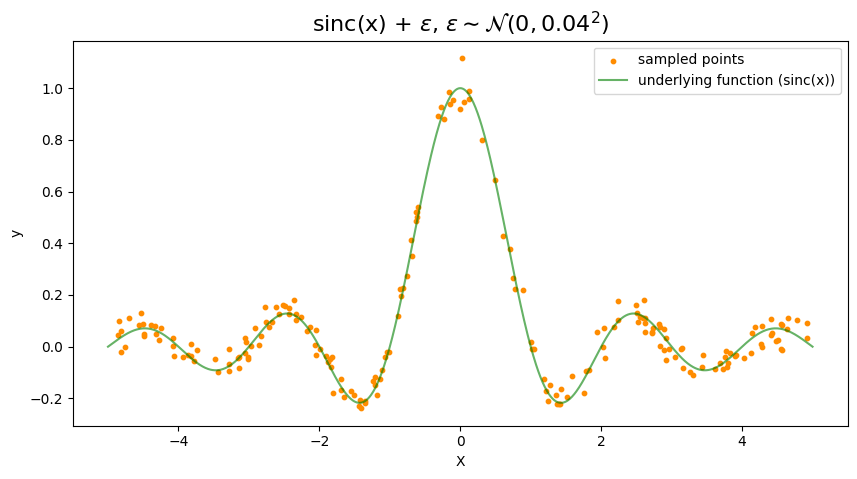

In [14]:
def underlying_function(X):
    base_function = torch.sinc(X)
    noise_std = 0.04
    noise = noise_std * torch.randn_like(X)
    return base_function + noise

n_samples = 200

train_data = torch.sort(10 * torch.rand(n_samples, 1) - 5)[0]
train_labels = underlying_function(train_data)

test_data = torch.linspace(-5, 5, 1000).unsqueeze(1)
test_labels_with_noise = underlying_function(test_data)
test_labels = torch.sinc(test_data)

plt.figure(figsize=(10, 5))
plt.scatter(train_data.numpy(), train_labels.numpy(), color='darkorange',s=10, label='sampled points')
plt.plot(test_data.numpy(), test_labels.numpy(), color='green', alpha=0.6, label='underlying function (sinc(x))')
plt.xlabel('X')
plt.ylabel('y')
plt.title(r'sinc(x) + $\epsilon$, $\epsilon \sim \mathcal{N}(0, 0.04^2)$', fontsize=16)
plt.legend()
plt.show()


In [18]:
sigma=.05
_lambda=sigma**2/train_data.shape[0]

num_inducing_points = int(train_data.shape[0] * .2)
print("total inducing poitns : ",num_inducing_points)
lengthscale = 0.1 

inducing_points = train_data[np.random.choice(train_data.shape[0], num_inducing_points, replace=False)]
inducing_points = torch.tensor(inducing_points, dtype=torch.float64).clone().detach()




total inducing poitns :  40


C:\Users\chris\AppData\Local\Temp\ipykernel_8332\3524872797.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inducing_points = torch.tensor(inducing_points, dtype=torch.float64).clone().detach()


C:\Users\chris\AppData\Local\Temp\ipykernel_8332\524923935.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
C:\Users\chris\AppData\Local\Temp\ipykernel_8332\524923935.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
C:\Users\chris\AppData\Local\Temp\ipykernel_8332\524923935.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data_tensor = torch.tensor(test_data, dtype=torch.float32)
C:\Users\ch

Gaussian Process Regression (GPR) RMSE: 0.4151
Sparse Variational Gaussian Process (SVGP) RMSE: 0.4148
Kernel Ridge Regression (KRR) RMSE: 0.0292
Nystrom KRR RMSE: 0.0205


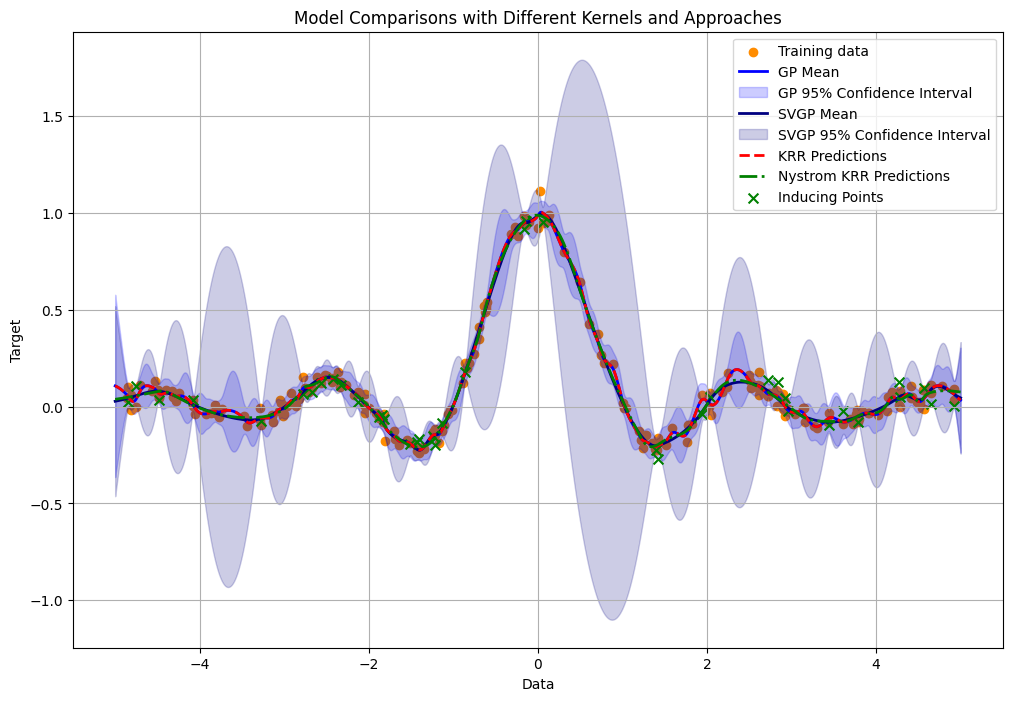

In [21]:


train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_data_tensor = torch.tensor(test_data, dtype=torch.float32)
inducing_points_tensor = torch.tensor(inducing_points, dtype=torch.float32)

# Gaussian Process Regression
gpr = GaussianProcessRegression(kernel=MaternKernel, sigma=sigma, dtype=global_dtype)
gpr.fit(train_data_tensor, train_labels_tensor)
GP_mean, GP_covariance = gpr.predict(test_data_tensor)
GP_std = np.sqrt(np.diag(GP_covariance))

# Sparse Variational Gaussian Process
svgp = SparseVariationalGaussianProcess(inducing_points_tensor, lengthscale=lengthscale, sigma=sigma, kernel=MaternKernel)
svgp.fit(train_data_tensor, train_labels_tensor)
mean_torch, covariance_torch = svgp.predict(test_data_tensor)
SVGP_mean = mean_torch.detach().numpy()
SVG_covariance = covariance_torch.detach().numpy()
SVGP_std = np.sqrt(np.diag(SVG_covariance))

# Kernel Ridge Regression
krr = KernelRidgeRegression(_lambda=_lambda, lengthscale=lengthscale, kernel=MaternKernel, dtype=global_dtype)
krr.fit(train_data_tensor, train_labels_tensor)
Krr_preds = krr.predict(test_data_tensor).detach().numpy()

# Nystrom KRR
nystrom_krr = NystromKRR(_lambda=_lambda, lengthscale=lengthscale, m=num_inducing_points, kernel=MaternKernel, dtype=global_dtype)
nystrom_krr.fit(train_data_tensor, train_labels_tensor)
NKrr_preds = nystrom_krr.predict(test_data_tensor).detach().numpy()

# Compute RMSE for each model
def compute_rmse(true_values, predicted_values):
    return np.sqrt(np.mean((true_values - predicted_values) ** 2))

test_labels = np.array(test_labels) 
GP_rmse = compute_rmse(test_labels, GP_mean)
SVGP_rmse = compute_rmse(test_labels, SVGP_mean)
Krr_rmse = compute_rmse(test_labels, Krr_preds)
NKrr_rmse = compute_rmse(test_labels, NKrr_preds)
print(f"Gaussian Process Regression (GPR) RMSE: {GP_rmse:.4f}")
print(f"Sparse Variational Gaussian Process (SVGP) RMSE: {SVGP_rmse:.4f}")
print(f"Kernel Ridge Regression (KRR) RMSE: {Krr_rmse:.4f}")
print(f"Nystrom KRR RMSE: {NKrr_rmse:.4f}")


underlying_values = underlying_function(inducing_points_tensor).detach().numpy()
# Plotting
plt.figure(figsize=(12, 8))
plt.scatter(train_data, train_labels, color='darkorange', label='Training data')
plt.plot(test_data, GP_mean, color='blue', lw=2, label='GP Mean')
plt.fill_between(test_data.ravel(), GP_mean - 1.96 * GP_std, GP_mean + 1.96 * GP_std, color='blue', alpha=0.2, label='GP 95% Confidence Interval')
plt.plot(test_data, SVGP_mean, color='navy', lw=2, label='SVGP Mean')
plt.fill_between(test_data.ravel(), SVGP_mean - 1.96 * SVGP_std, SVGP_mean + 1.96 * SVGP_std, color='navy', alpha=0.2, label='SVGP 95% Confidence Interval')
plt.plot(test_data, Krr_preds, color='red', lw=2, linestyle='--', label='KRR Predictions')
plt.plot(test_data, NKrr_preds, color='green', lw=2, linestyle='-.', label='Nystrom KRR Predictions')
plt.scatter(inducing_points, underlying_values, color='green', s=50, label='Inducing Points', marker='x')
plt.xlabel('Data')
plt.ylabel('Target')
plt.title('Model Comparisons with Different Kernels and Approaches')
plt.legend()
plt.grid(True)
plt.show()


Norm of the difference (GP vs. SVGP): 0.6226584117857558
Relative norm of the difference (GP vs. SVGP): 0.06292828170049099
Norm of the difference (KRR vs. NKRR): 0.6054506746906207
Relative norm of the difference (KRR vs. NKRR): 0.0612962870365919
Norm of the difference (SVGP vs. NKRR): 0.2948262821940937
Relative norm of the difference (SVGP vs. NKRR): 0.029953807563739606


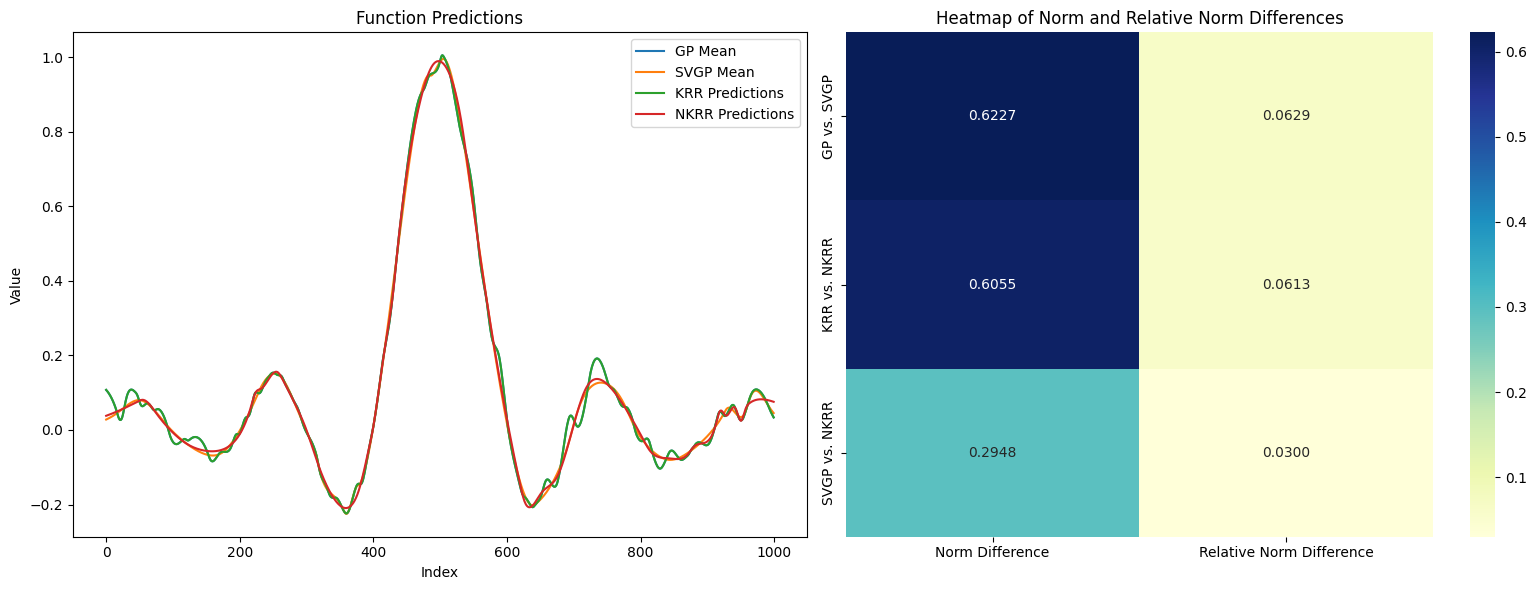

In [23]:
Krr_preds = Krr_preds.flatten()
NKrr_preds = NKrr_preds.flatten()

norm_diff_gpsvgp = np.linalg.norm(GP_mean - SVGP_mean)
norm_diff_krrnkrr = np.linalg.norm(Krr_preds - NKrr_preds)
norm_diff_svpgnkrr = np.linalg.norm(SVGP_mean - NKrr_preds)

relative_norm_diff_gpsvgp = norm_diff_gpsvgp / np.linalg.norm(GP_mean)
relative_norm_diff_krrnkrr = norm_diff_krrnkrr / np.linalg.norm(NKrr_preds)
relative_norm_diff_svpgnkrr = norm_diff_svpgnkrr / np.linalg.norm(SVGP_mean)

print(f"Norm of the difference (GP vs. SVGP): {norm_diff_gpsvgp}")
print(f"Relative norm of the difference (GP vs. SVGP): {relative_norm_diff_gpsvgp}")
print(f"Norm of the difference (KRR vs. NKRR): {norm_diff_krrnkrr}")
print(f"Relative norm of the difference (KRR vs. NKRR): {relative_norm_diff_krrnkrr}")
print(f"Norm of the difference (SVGP vs. NKRR): {norm_diff_svpgnkrr}")
print(f"Relative norm of the difference (SVGP vs. NKRR): {relative_norm_diff_svpgnkrr}")

difference_matrix = np.array([
    [norm_diff_gpsvgp, relative_norm_diff_gpsvgp],
    [norm_diff_krrnkrr, relative_norm_diff_krrnkrr],
    [norm_diff_svpgnkrr, relative_norm_diff_svpgnkrr]
])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(GP_mean, label='GP Mean')
ax1.plot(SVGP_mean, label='SVGP Mean')
ax1.plot(Krr_preds, label='KRR Predictions')
ax1.plot(NKrr_preds, label='NKRR Predictions')
ax1.set_xlabel('Index')
ax1.set_ylabel('Value')
ax1.set_title('Function Predictions')
ax1.legend()
import seaborn as sns 
sns.heatmap(difference_matrix, annot=True, fmt=".4f", cmap="YlGnBu", xticklabels=['Norm Difference', 'Relative Norm Difference'], yticklabels=['GP vs. SVGP', 'KRR vs. NKRR', 'SVGP vs. NKRR'], ax=ax2)
ax2.set_title('Heatmap of Norm and Relative Norm Differences')

plt.tight_layout()
plt.show()
